<a href="https://colab.research.google.com/github/viswakimi/Multiclass-Fish-Image-Classification/blob/main/imageclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass Fish Image Classification

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0

In [ ]:
# Define Constants
Train_Path = "D:\\App\\vscode1\\fish image\\Dataset\\images.cv_jzk6llhf18tm3k0kyttxz\\data\\train"
Test_Path = "D:\\App\\vscode1\\fish image\\Dataset\\images.cv_jzk6llhf18tm3k0kyttxz\\data\\test"
Validation_Path = "D:\\App\\vscode1\\fish image\\Dataset\\images.cv_jzk6llhf18tm3k0kyttxz\\data\\val"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_CNN = 10
EPOCHS_PRETRAINED = 5
BEST_MODEL_PATH = "D:\\App\\vscode1\\fish image\\Dataset\\images.cv_jzk6llhf18tm3k0kyttxz\\data\\best_fish_model.keras"

### Data Preprocessing and Augmentation


Rescale images to [0, 1] range.
Apply data augmentation techniques like rotation, zoom, and flipping to enhance model robustness.


In [ ]:
# Data Preprocessing and Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)


In [ ]:
# Create data generators for training, validation, and testing
train_gen = datagen.flow_from_directory(
    Train_Path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    Validation_Path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    Test_Path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


# Model Training

## Train a CNN model from scratch.

In [ ]:
# Function to Create CNN Model
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(train_gen.class_indices), activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Experiment with five pre-trained models (e.g., VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0)


In [ ]:
# Function to Create Pre-trained Model
def create_pretrained_model(base_model_name):
    base_models = {
        "VGG16": VGG16,
        "ResNet50": ResNet50,
        "MobileNet": MobileNet,
        "InceptionV3": InceptionV3,
        "EfficientNetB0": EfficientNetB0
    }
    base_model = base_models[base_model_name](weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    base_model.trainable = True  # Enable fine-tuning
    for layer in base_model.layers[:100]:  # Freeze first 100 layers
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(train_gen.class_indices), activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


Fine-tune the pre-trained models on the fish dataset.
Save the trained model (max accuracy model ) in .h5 or .pkl format for future use.

In [ ]:
# Training and Evaluation Loop
models = {"CNN": create_cnn_model()}
for model_name in ["VGG16", "ResNet50", "MobileNet", "InceptionV3", "EfficientNetB0"]:
    models[model_name] = create_pretrained_model(model_name)

best_model = None
best_accuracy = 0
history_dict = {}
metrics_dict = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    checkpoint = ModelCheckpoint(BEST_MODEL_PATH, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS_CNN if model_name == 'CNN' else EPOCHS_PRETRAINED, callbacks=[checkpoint, early_stopping])
    history_dict[model_name] = history.history

    val_preds = np.argmax(model.predict(val_gen), axis=1)
    val_labels = val_gen.classes

    accuracy = accuracy_score(val_labels, val_preds)
    metrics_dict[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision_score(val_labels, val_preds, average='macro', zero_division=1),
        "Recall": recall_score(val_labels, val_preds, average='macro'),
        "F1 Score": f1_score(val_labels, val_preds, average='macro'),
        "Confusion Matrix": confusion_matrix(val_labels, val_preds)
    }

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

# Save the Best Model
if best_model:
    best_model.save(BEST_MODEL_PATH)
    joblib.dump(metrics_dict, "model_metrics.pkl")


Training CNN...
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.2319 - loss: 2.3555
Epoch 1: val_accuracy improved from -inf to 0.48626, saving model to D:\App\vscode1\fish image\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\best_fish_model.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 182s 920ms/step - accuracy: 0.2323 - loss: 2.3534 - val_accuracy: 0.4863 - val_loss: 1.4481
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.4905 - loss: 1.4136
Epoch 2: val_accuracy improved from 0.48626 to 0.72161, saving model to D:\App\vscode1\fish image\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\best_fish_model.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 177s 904ms/step - accuracy: 0.4907 - loss: 1.4130 - val_accuracy: 0.7216 - val_loss: 0.8336
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.6523 - loss: 0.9781
Epoch 3: val_accuracy improved from 0.72161 to 0.82601, saving model to D:\App\vscode1\fish image\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\best_fis

# Model Evaluation

Model Performance Comparison:


Model Performance Comparison:

                Accuracy  Precision    Recall  F1 Score
CNN             0.099817   0.085110  0.085522  0.085025
VGG16           0.122711   0.196677  0.106986  0.106143
ResNet50        0.171245   0.924659  0.090909  0.026583
MobileNet       0.113553   0.101576  0.101948  0.101758
InceptionV3     0.087912   0.076789  0.076927  0.076853
EfficientNetB0  0.091575   0.172223  0.082661  0.079797


<Figure size 1000x600 with 0 Axes>

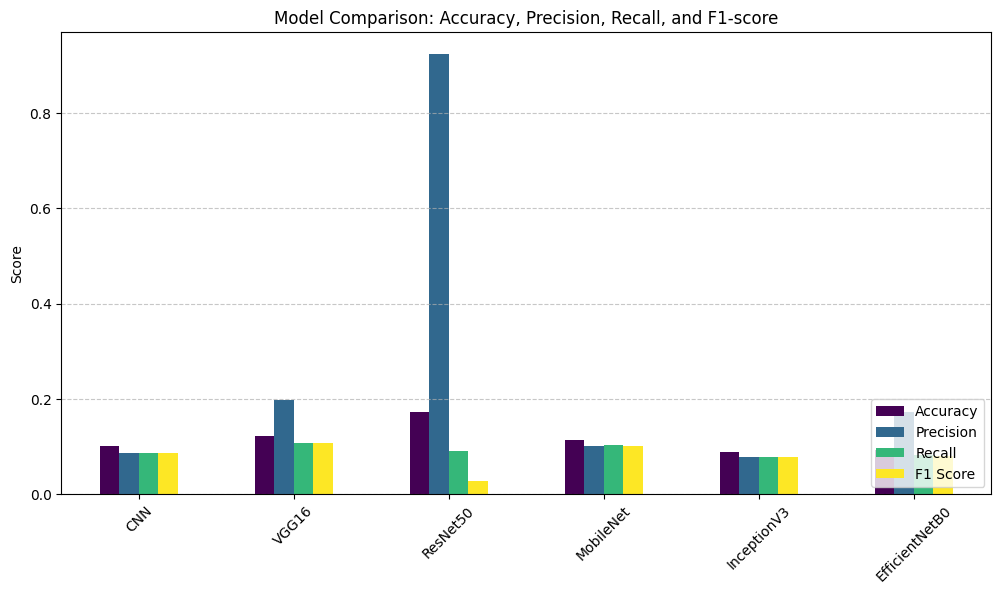

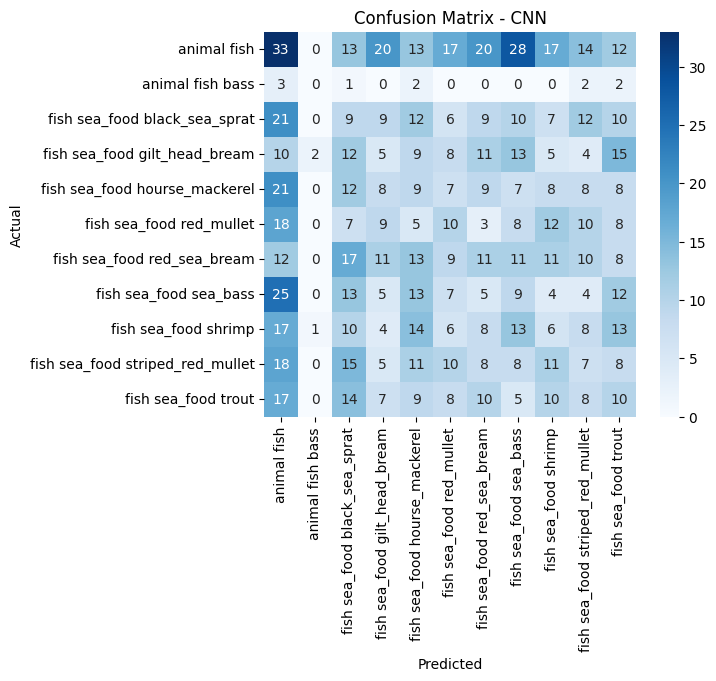

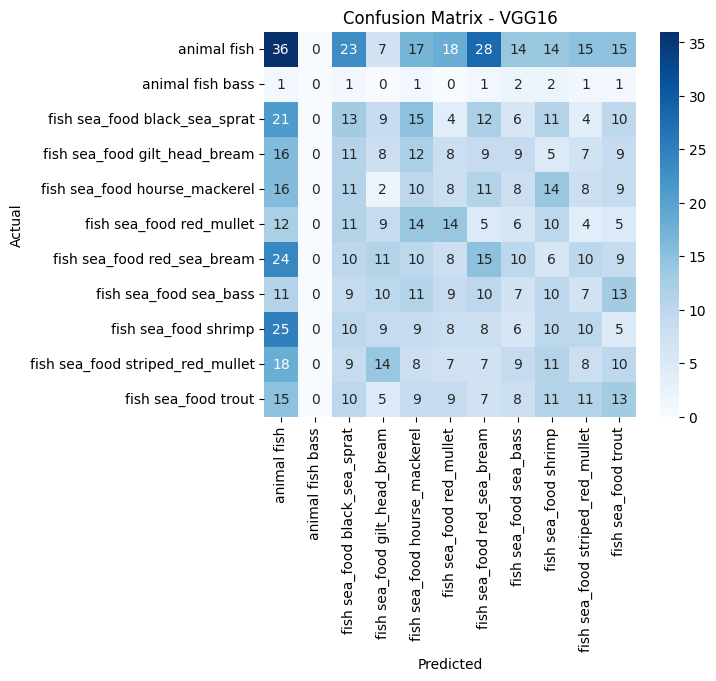

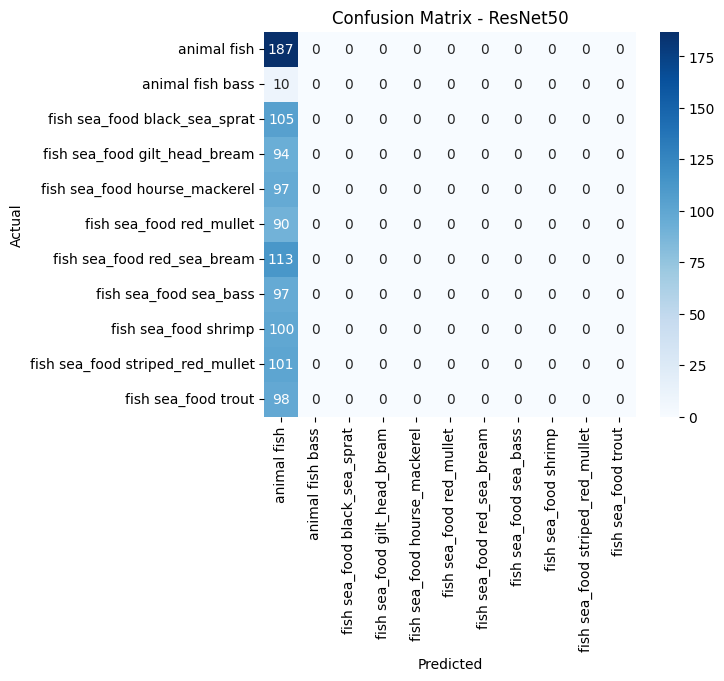

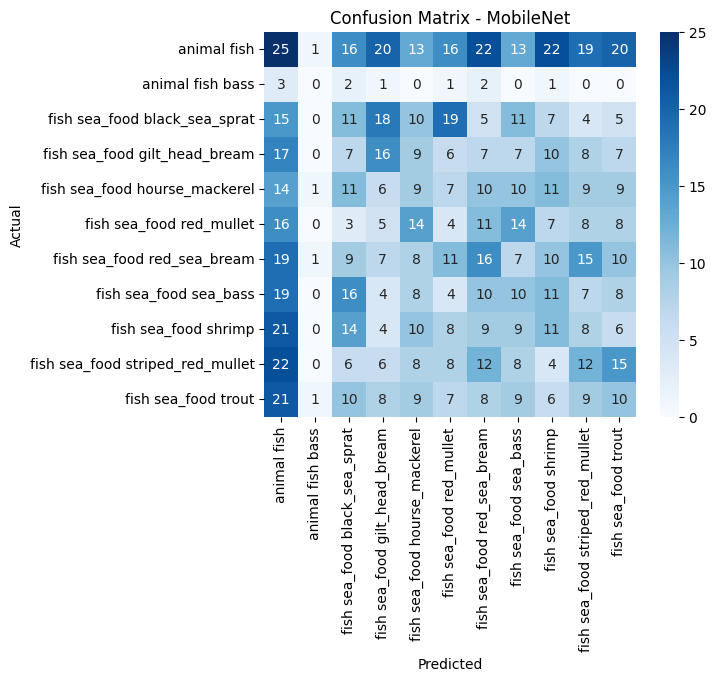

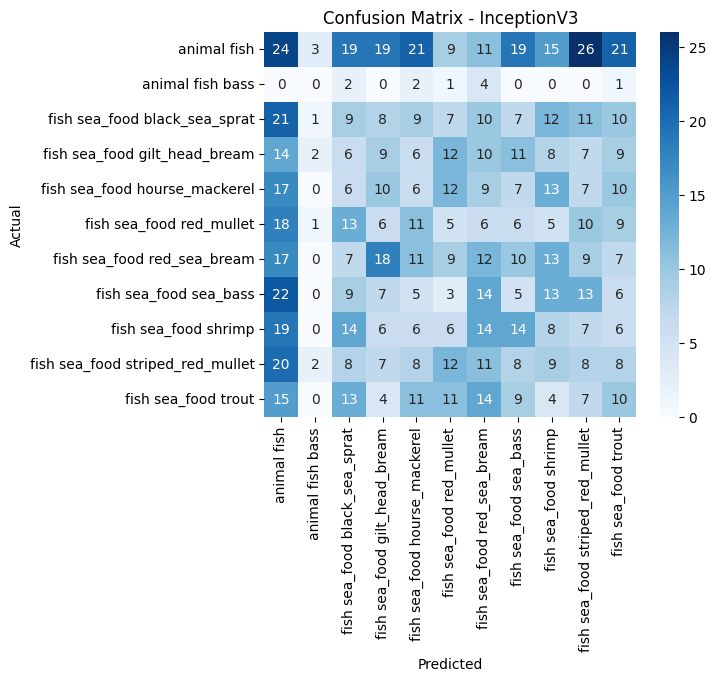

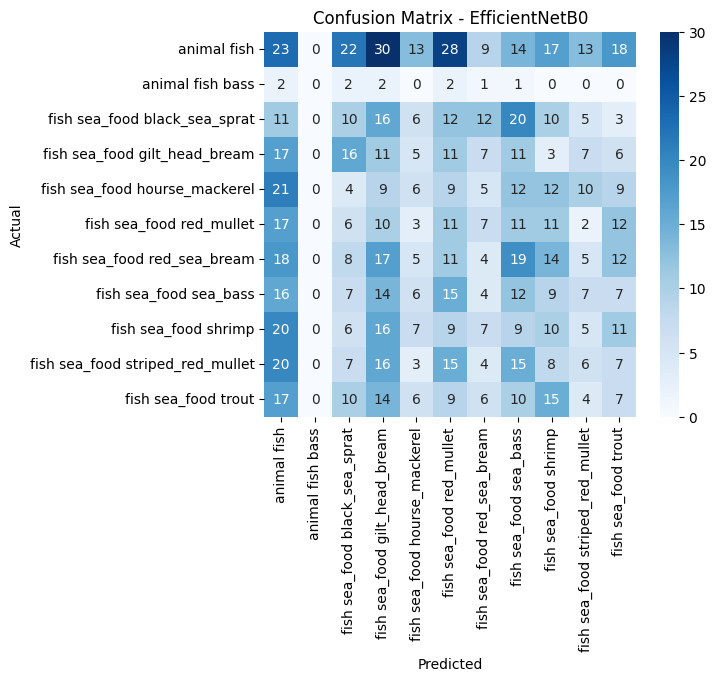

In [ ]:
# Load saved metrics
metrics_dict = joblib.load("model_metrics.pkl")

# Convert metrics_dict to a DataFrame for easy visualization
import pandas as pd

metrics_df = pd.DataFrame.from_dict({model: {k: v for k, v in metrics_dict[model].items() if k != "Confusion Matrix"} for model in metrics_dict}, orient='index')

# Print the comparison table
print("\nModel Performance Comparison:\n")
print(metrics_df)

# Plot comparison of accuracy, precision, recall, and F1-score
plt.figure(figsize=(10, 6))
metrics_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title("Model Comparison: Accuracy, Precision, Recall, and F1-score")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Plot Confusion Matrices for each model
for model_name in metrics_dict:
    plt.figure(figsize=(6, 5))
    cm = metrics_dict[model_name]["Confusion Matrix"]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## Visualize training history (accuracy and loss) for each model.


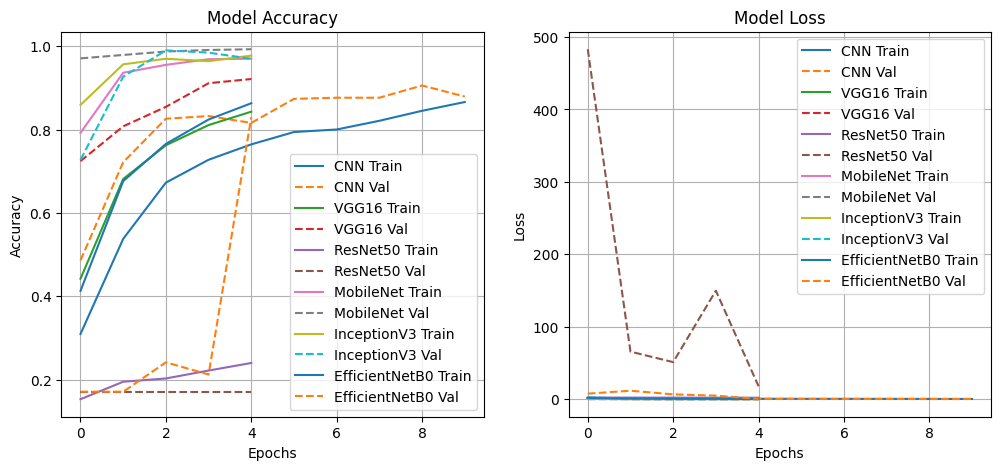

In [ ]:
# Plot training history: Accuracy & Loss
plt.figure(figsize=(12, 5))

for model_name, history in history_dict.items():
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label=f"{model_name} Train")
    plt.plot(history['val_accuracy'], linestyle='dashed', label=f"{model_name} Val")
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label=f"{model_name} Train")
    plt.plot(history['val_loss'], linestyle='dashed', label=f"{model_name} Val")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

plt.show()


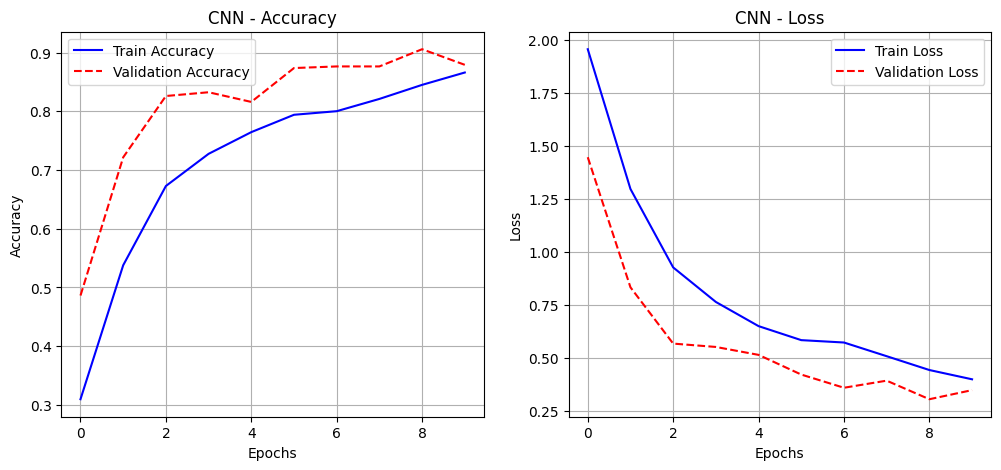

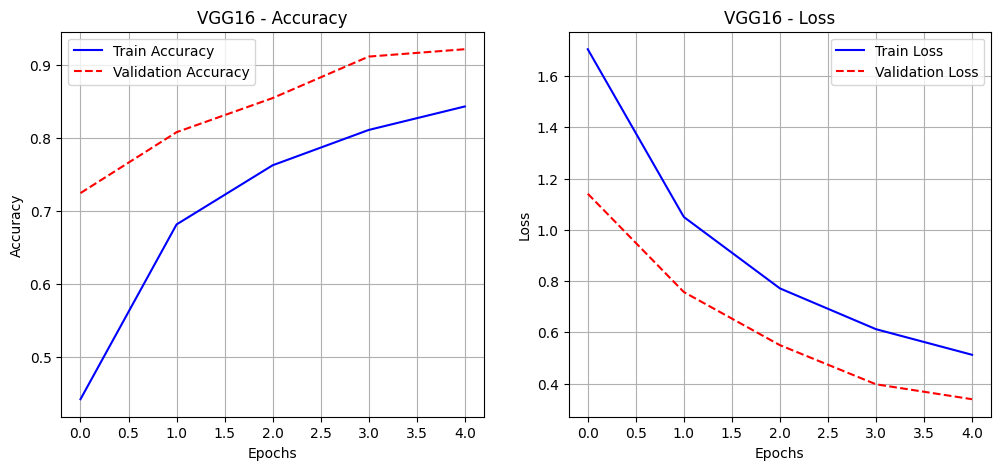

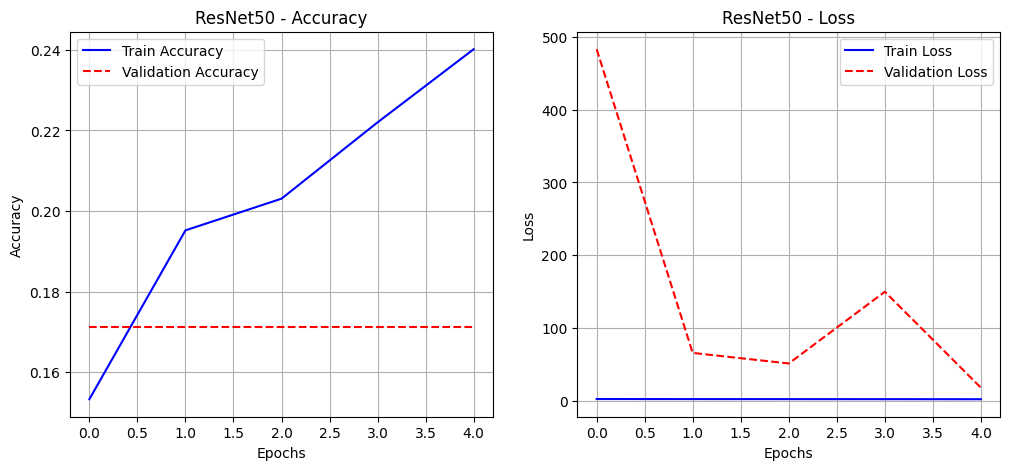

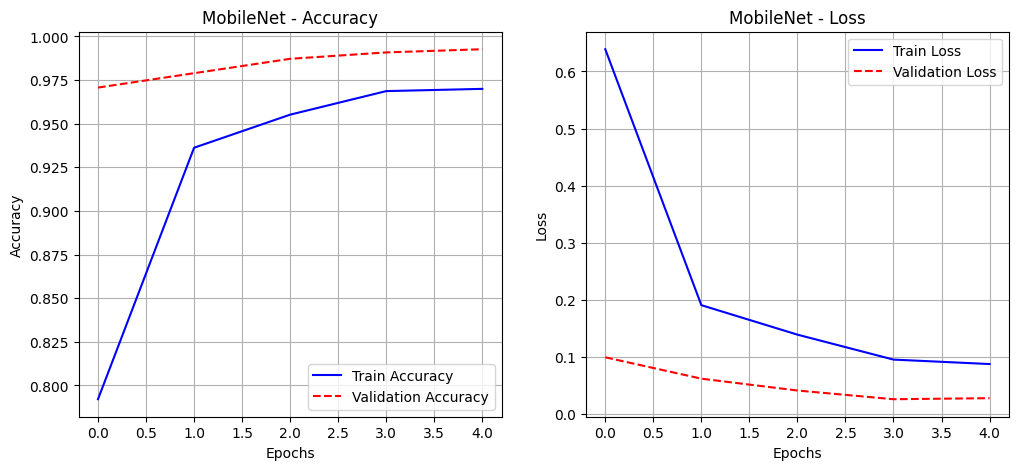

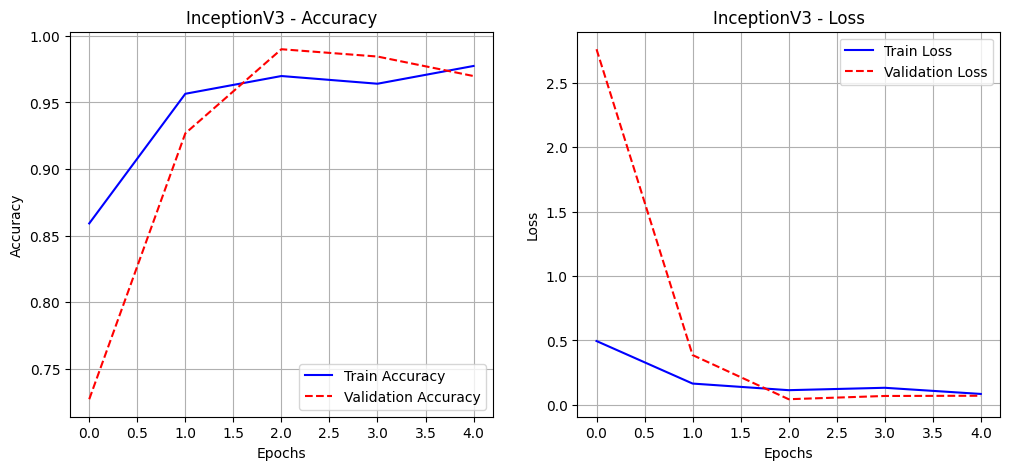

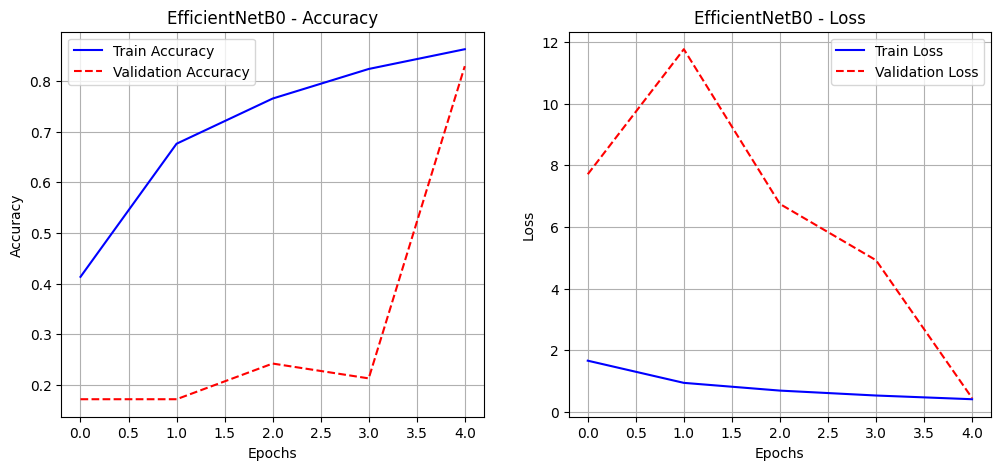

In [ ]:
# Plot training history separately for each model
for model_name, history in history_dict.items():
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label="Train Accuracy", color='blue')
    plt.plot(history['val_accuracy'], label="Validation Accuracy", linestyle='dashed', color='red')
    plt.title(f"{model_name} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label="Train Loss", color='blue')
    plt.plot(history['val_loss'], label="Validation Loss", linestyle='dashed', color='red')
    plt.title(f"{model_name} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Show the plots for this model
    plt.show()


Display Sample Predictions

d:\App\vscode1\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step


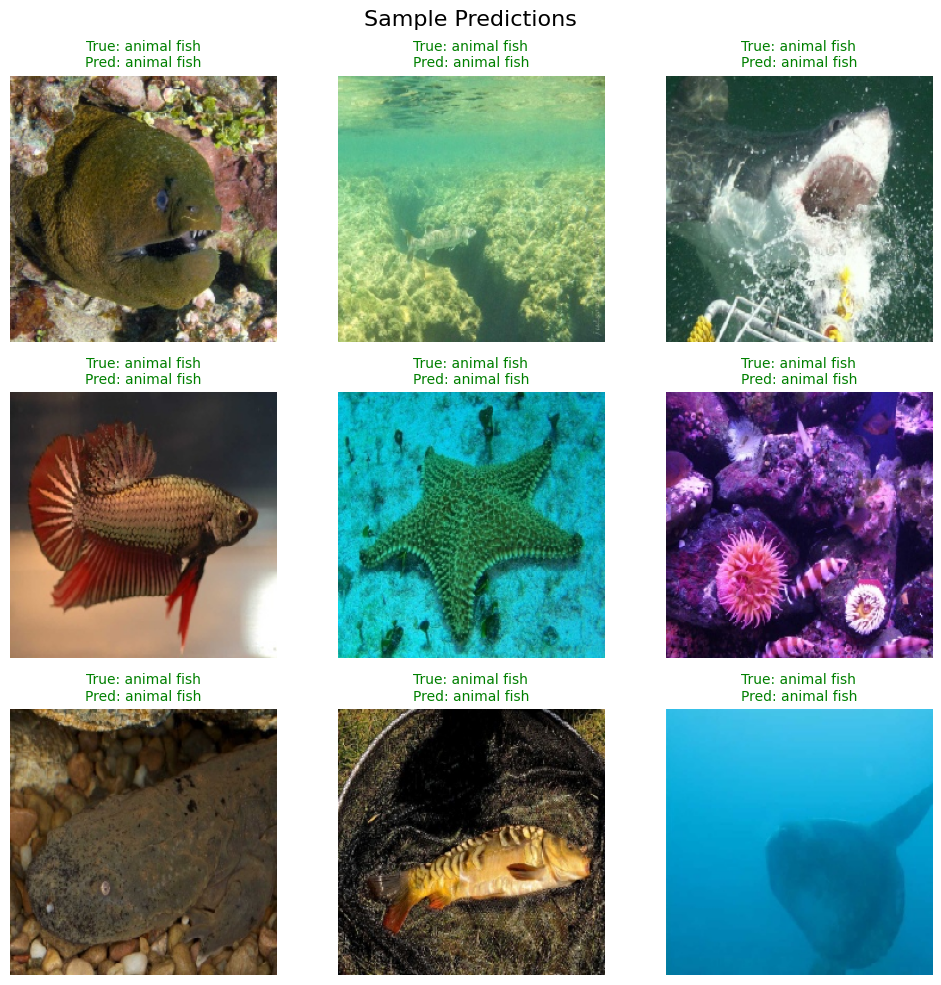

In [ ]:
# Make predictions on the test dataset
model = load_model(BEST_MODEL_PATH)  # Load the best saved model
test_preds = np.argmax(model.predict(test_gen), axis=1)  # Get predicted class indices
class_labels = list(test_gen.class_indices.keys())  # Get class labels
test_images, test_labels = next(test_gen)  # Get a batch of test images and labels

# Display Sample Predictions
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3x3 grid of sample images
fig.suptitle("Sample Predictions", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i >= len(test_images):  # Avoid index error if batch has fewer images
        break
    ax.imshow(test_images[i])  # Show image
    true_label = class_labels[np.argmax(test_labels[i])]  # Get true label
    pred_label = class_labels[test_preds[i]]  # Get predicted label

    # Display results
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color="green" if true_label == pred_label else "red")
    ax.axis("off")  # Hide axis

plt.tight_layout()
plt.show()


Best model summary

In [ ]:
# Load the best model and display its summary
best_model = load_model(BEST_MODEL_PATH)
best_model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,075,683 (244.43 MB)

 Trainable params: 19,980,299 (76.22 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

 Optimizer params: 39,960,600 (152.44 MB)

## ROC Curve for Multi-Class Classification

100/100 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step


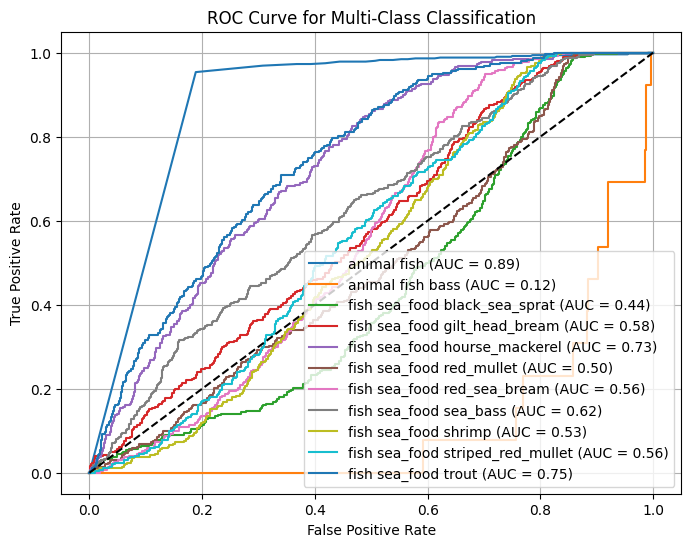

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(model, test_gen):
    y_true = test_gen.classes  # True labels
    y_pred_proba = model.predict(test_gen)  # Get probability predictions
    y_true_bin = label_binarize(y_true, classes=range(len(class_labels)))  # Convert to binary labels

    plt.figure(figsize=(8, 6))

    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Multi-Class Classification")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Call the function
plot_roc_curve(best_model, test_gen)


## Train vs Validation Accuracy for Each Model

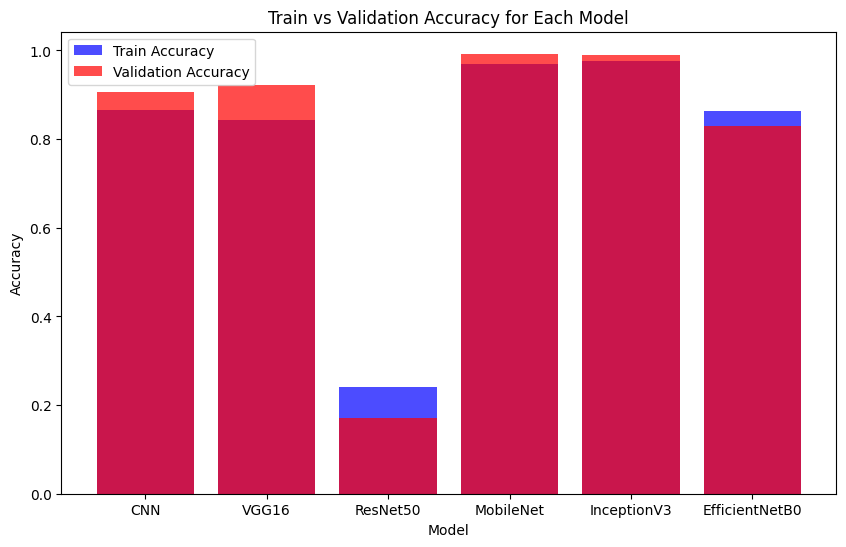

In [ ]:
# Extract accuracy and training time
model_names = list(history_dict.keys())
train_accuracies = [max(history['accuracy']) for history in history_dict.values()]
val_accuracies = [max(history['val_accuracy']) for history in history_dict.values()]

# Plot model performance
plt.figure(figsize=(10, 6))
plt.bar(model_names, train_accuracies, label="Train Accuracy", alpha=0.7, color='blue')
plt.bar(model_names, val_accuracies, label="Validation Accuracy", alpha=0.7, color='red')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy for Each Model")
plt.legend()
plt.show()


# Classification Report

100/100 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step

Classification Report:
                                   precision    recall  f1-score   support

                     animal fish       0.16      1.00      0.28       520
                animal fish bass       1.00      0.00      0.00        13
   fish sea_food black_sea_sprat       1.00      0.00      0.00       298
   fish sea_food gilt_head_bream       1.00      0.00      0.00       305
   fish sea_food hourse_mackerel       1.00      0.00      0.00       286
        fish sea_food red_mullet       1.00      0.00      0.00       291
     fish sea_food red_sea_bream       1.00      0.00      0.00       273
          fish sea_food sea_bass       1.00      0.00      0.00       327
            fish sea_food shrimp       1.00      0.00      0.00       289
fish sea_food striped_red_mullet       1.00      0.00      0.00       293
             fish sea_food trout       0.12      0.00      0.01       292

                        accuracy           

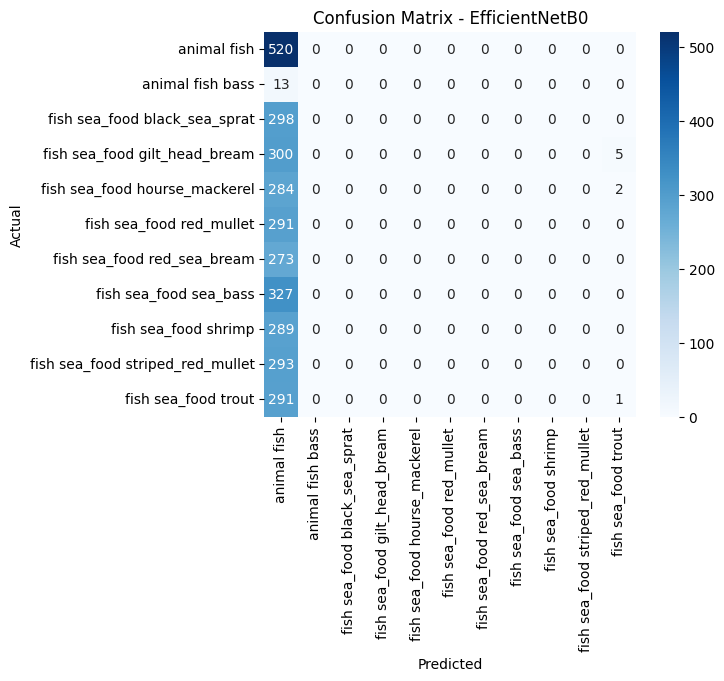

['updated_model_metrics.pkl']

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure the best model is loaded
best_model = load_model(BEST_MODEL_PATH)

# Predict on the test dataset
y_true = test_gen.classes  # True labels
y_pred_proba = best_model.predict(test_gen)  # Probability predictions
y_pred = np.argmax(y_pred_proba, axis=1)  # Get predicted class indices

# Generate Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels, zero_division=1)
print("\nClassification Report:\n", report)

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title(f"Confusion Matrix - {model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save Metrics for Future Reference
metrics_dict["Best Model"] = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred, average='macro', zero_division=1),
    "Recall": recall_score(y_true, y_pred, average='macro', zero_division=1),
    "F1 Score": f1_score(y_true, y_pred, average='macro', zero_division=1),
    "Confusion Matrix": cm
}

# Save the updated metrics
joblib.dump(metrics_dict, "updated_model_metrics.pkl")
